In [14]:
# 调用相关库
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import pandas as pd
from math import sqrt
import random
from numpy import concatenate
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score
import scipy as spy
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pandas import DataFrame
from pandas import concat
import numpy
from scipy.io import savemat,loadmat
import os

In [15]:
# 转换成监督数据，将每个特征转换成21列数据，20->1，20组预测一组
def series_to_supervised(data, n_in=20, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]  #计算特征的数量
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    # 将20组输入数据依次向下移动20,19,...3,2,1行，将数据加入cols列表（技巧：(n_in, 0, -1)中的-1指倒序循环，步长为1）
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    # 将一组输出数据加入cols列表（技巧：其中i=0）
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # cols列表(list)中现在有21块经过下移后的数据(即：df(-20),df(-19),...df(-2),df(-1),df)，将四块数据按列 并排合并
    agg = pd.concat(cols, axis=1)
    # 给合并后的数据添加列名
    agg.columns = names
    # print(agg)
    # 删除NaN值列
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [16]:
dataset = pd.read_excel("816480.xlsx")
fratures_Corrected_irradiance = [
    'Flow (Veh/5 Minutes)'
]
values = dataset[fratures_Corrected_irradiance].values
n_features=1 #特征数量

In [17]:
# 标准化
scaler =StandardScaler()
scaled = scaler.fit_transform(values)

In [18]:
n_in = 3
n_out = 1
# 构造一个20->1的监督学习型数据
reframed = series_to_supervised(scaled, n_in=n_in, n_out=n_out)
values=reframed.values

In [19]:
#训练集和测试集的划分比例
ratio=0.8 
N=int(len(values) *ratio)
train = values[:N, :]
test = values[N:, :]

# 划分输入和输出,split into input and outputs
n_obs = n_in * n_features
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1149, 3) (1149,) (288, 3) (288,)


In [20]:
train_y=train_y.reshape(len(train_y))
train_y.shape

(1149,)

In [21]:
class HiddenLayer:
    def __init__(self, x, num):  # x：输入矩阵   num：隐含层神经元个数
        row = x.shape[0]
        columns = x.shape[1]
        rnd = np.random.RandomState(9999)
        self.w = rnd.uniform(-1, 1, (columns, num))  #
        self.b = np.zeros([row, num], dtype=float)  # 随机设定隐含层神经元阈值，即bi的值
        for i in range(num):
            rand_b = rnd.uniform(-0.4, 0.4)  # 随机产生-0.4 到 0.4 之间的数
            for j in range(row):
                self.b[j, i] = rand_b  # 设定输入层与隐含层的连接权值
        self.h = self.sigmoid(np.dot(x, self.w) + self.b)  # 计算隐含层输出矩阵H
        self.H_ = np.linalg.pinv(self.h)  # 获取H的逆矩阵
        # print(self.H_.shape)
 
    # 定义激活函数g(x) ，需为无限可微函数
    def sigmoid(self, x):
        print(x)
        return 1.0 / (1 + np.exp(-x))
 
    '''  若进行分析的训练数据为回归问题，则使用该方式 ，计算隐含层输出权值，即β '''
 
    def regressor_train(self, T):
        C = 2
        I = len(T)
        sub_former = np.dot(np.transpose(self.h), self.h) + I / C
        all_m = np.dot(np.linalg.pinv(sub_former), np.transpose(self.h))
        T = T.reshape(-1, 1)
        self.beta = np.dot(all_m, T)
        return self.beta
 
    """
           计算隐含层输出权值，即β 
    """
 
    def classifisor_train(self, T):
        en_one = OneHotEncoder()
        # print(T)
        T = en_one.fit_transform(T.reshape(-1, 1)).toarray()  # 独热编码之后一定要用toarray()转换成正常的数组
        # print(T)
        C = 3
        I = len(T)
        sub_former = np.dot(np.transpose(self.h), self.h) + I / C
        all_m = np.dot(np.linalg.pinv(sub_former), np.transpose(self.h))
        self.beta = np.dot(all_m, T)
        return self.beta
 
    def regressor_test(self, test_x):
        b_row = test_x.shape[0]
        h = self.sigmoid(np.dot(test_x, self.w) + self.b[:b_row, :])
        result = np.dot(h, self.beta)
        return result
 
    def classifisor_test(self, test_x):
        b_row = test_x.shape[0]
        h = self.sigmoid(np.dot(test_x, self.w) + self.b[:b_row, :])
        result = np.dot(h, self.beta)
        result = [item.tolist().index(max(item.tolist())) for item in result]
        return result


In [22]:
a = HiddenLayer(train_X,9)
a.regressor_train(train_y)

[[ 0.14539443  0.18786748 -0.5633439  ...  0.33564225  0.78348153
   0.09722481]
 [-0.04875939  0.03487941 -0.47001925 ...  0.40771562  0.7961676
   0.06877937]
 [ 0.11195781  0.33966691 -0.41753106 ...  0.32518954  0.72685124
   0.11505154]
 ...
 [ 0.24848668  0.13859807 -0.43078001 ...  0.21951659  0.63958966
   0.14357129]
 [ 0.24555506  0.07872032 -0.51515851 ...  0.24296554  0.68731137
   0.12821918]
 [ 0.1807654   0.10664611 -0.46763669 ...  0.27092228  0.6922235
   0.12169343]]


array([[  1.23710792],
       [ -3.82783536],
       [ -2.93955742],
       [ -2.08852658],
       [ -6.16352402],
       [  8.71349919],
       [  5.23873715],
       [-14.60977352],
       [ 14.43926586]])

In [23]:
#预测
yhat = a.regressor_test(test_X)
yhat=yhat.reshape(-1,1)
# 对预测结果进行反归一化
inv_yhat = scaler.inverse_transform(yhat)
# 将真实列据进行反归一化
test_y=test_y.reshape(-1,1)
inv_y = scaler.inverse_transform(test_y)

[[ 0.1676386   0.12812019 -0.46664692 ...  0.28143691  0.70110544
   0.11890596]
 [ 0.22770598  0.15337633 -0.55055016 ...  0.27526851  0.7298007
   0.11815964]
 [ 0.19621065  0.09290739 -0.61022638 ...  0.30821074  0.77539737
   0.10055644]
 ...
 [ 0.20883349  0.01070896 -0.45209551 ...  0.23639781  0.65457292
   0.13061828]
 [-0.11648957  0.02942766 -0.06943912 ...  0.31299878  0.56813639
   0.12252947]
 [-0.17158904  0.18045687  0.20721966 ...  0.27143896  0.43694056
   0.15802004]]


In [24]:
# 计算RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.7f' % rmse)
print('Test MAE: %.7f' % mean_absolute_error(inv_y, inv_yhat))
print('Test R2: %.7f' % r2_score(inv_y, inv_yhat))

Test RMSE: 34.5560939
Test MAE: 27.2617244
Test R2: 0.9551639


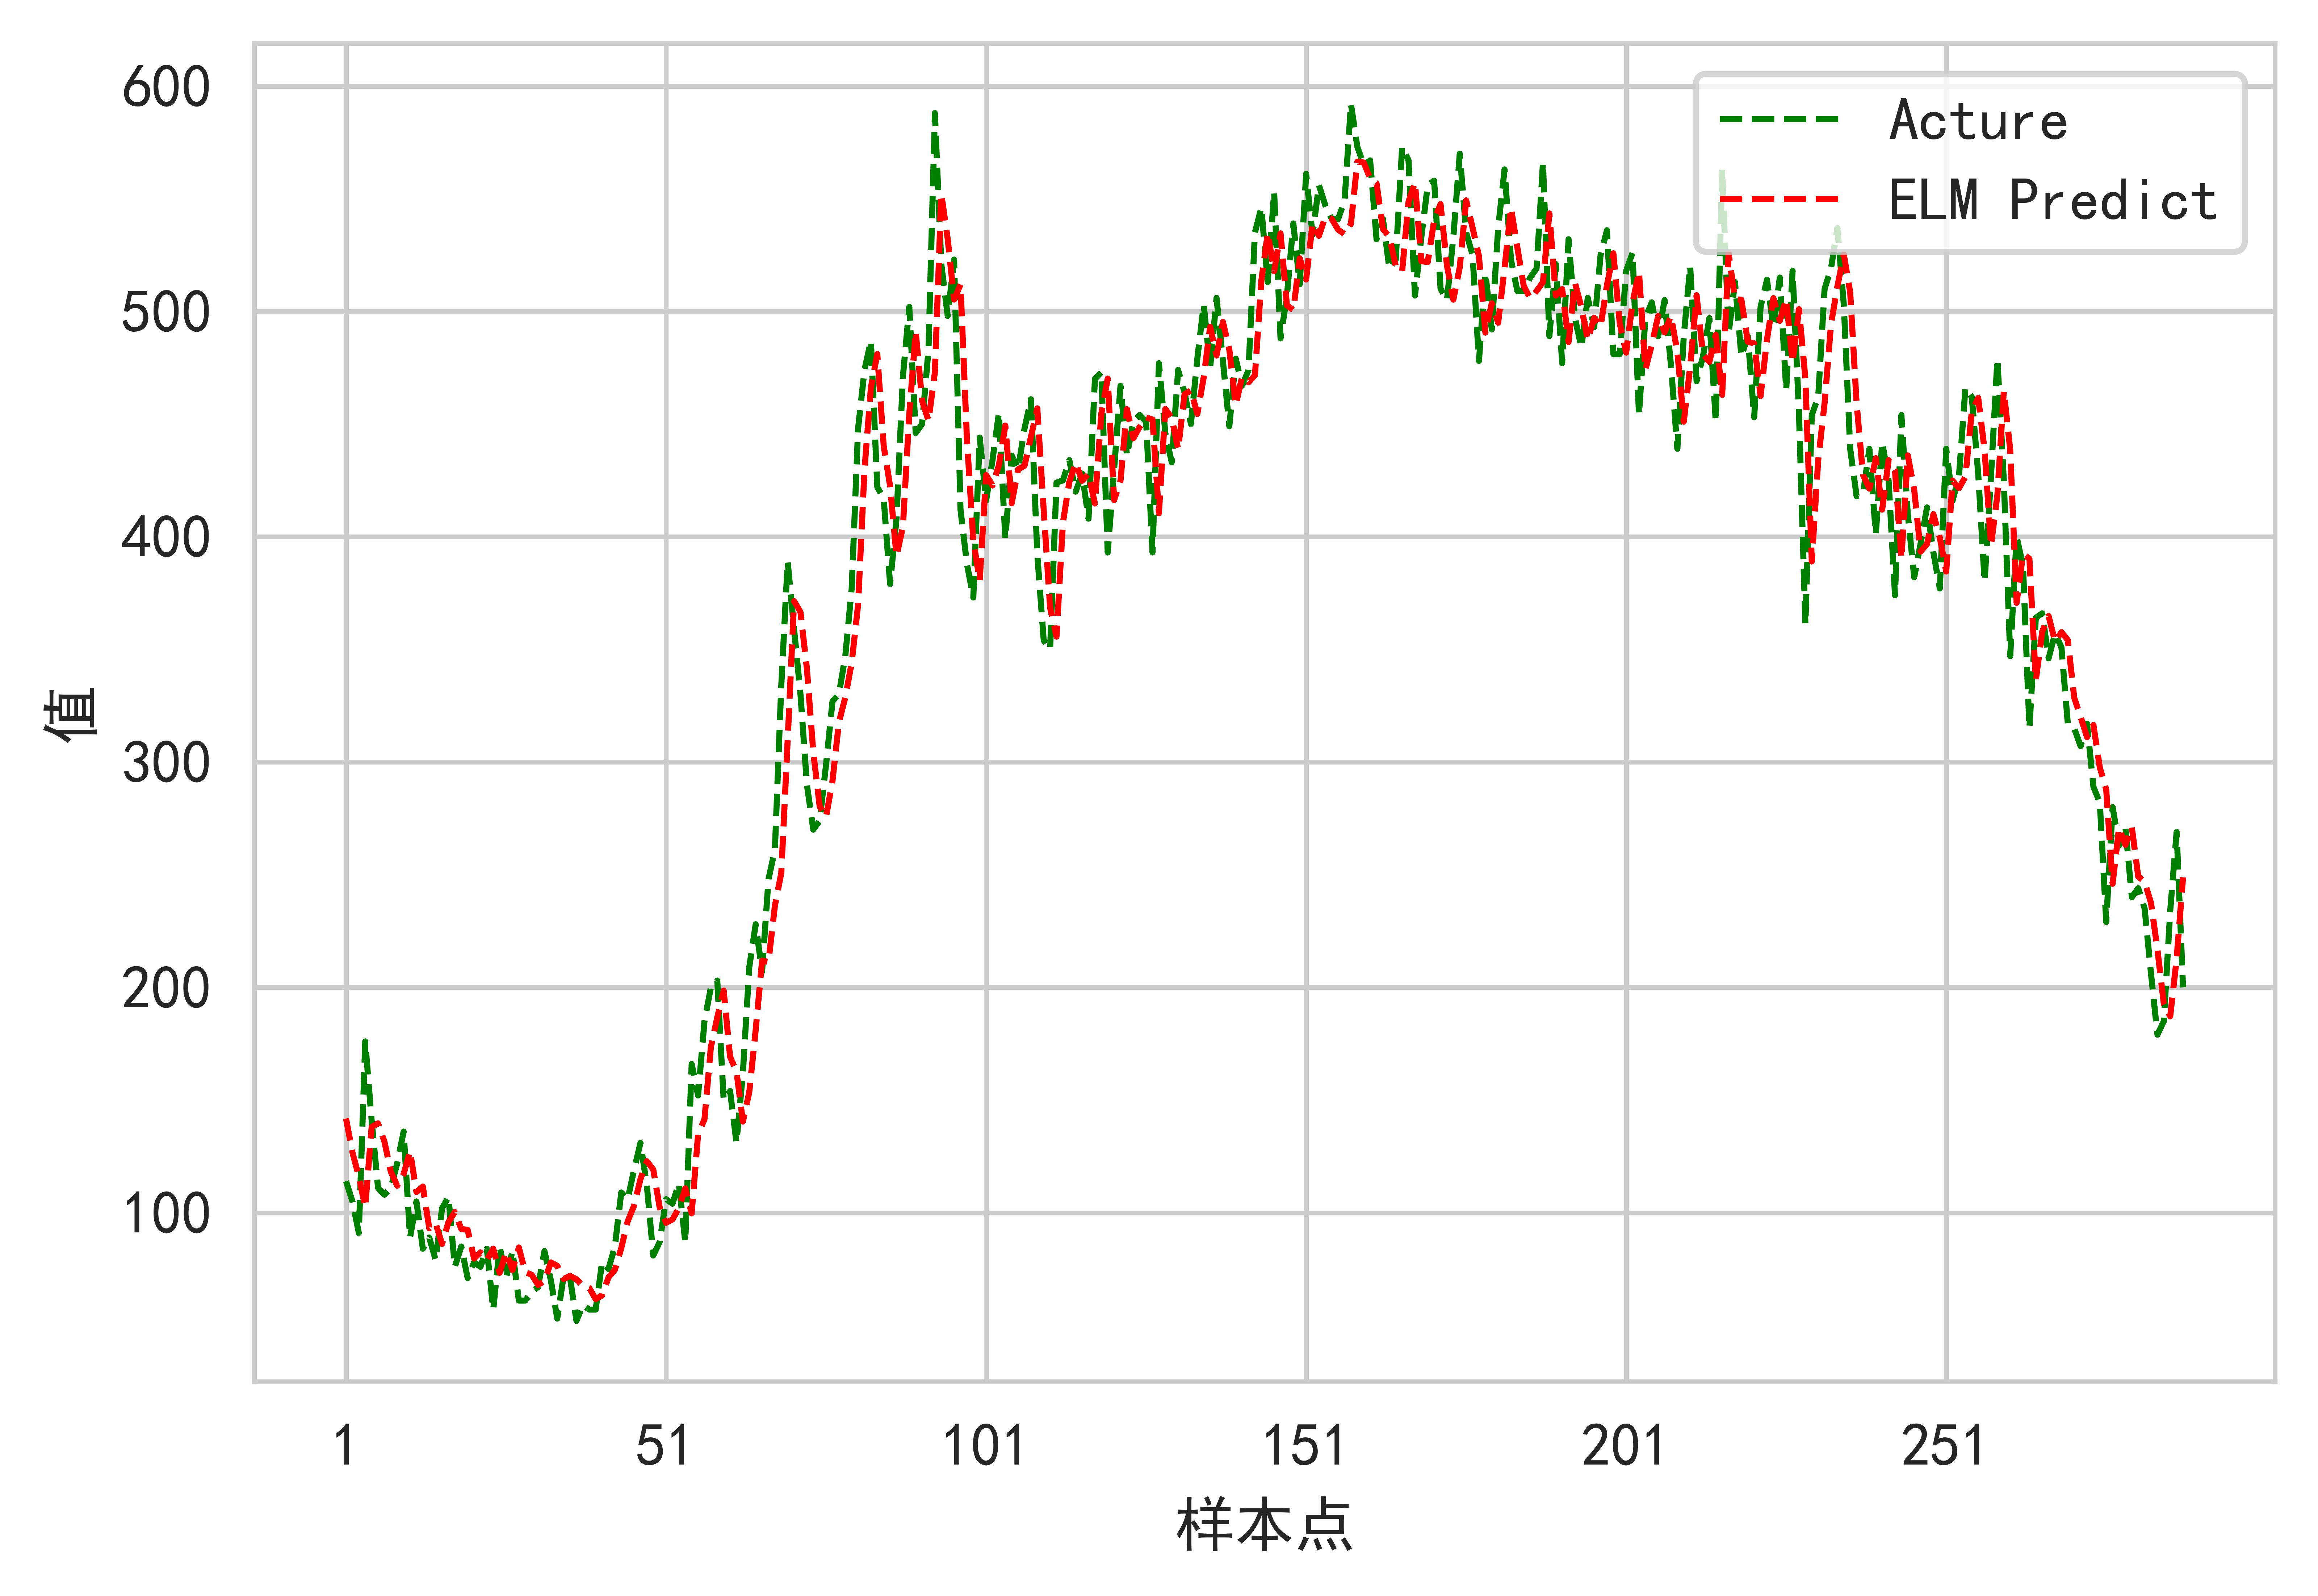

In [25]:
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
plt.rcParams['font.sans-serif']=['Simhei']  #解决画图中文不显示问题
plt.figure(figsize=(6,4),dpi=600)
x=range(1, len(inv_y) + 1)
plt.xticks(x[::50])
plt.tick_params(labelsize=10)  #改变刻度字体大小
plt.plot(x, inv_y, linestyle="--",color='g',linewidth=1, label='Acture')
plt.plot(x, inv_yhat,  color='red',linestyle="--",linewidth=1,label='ELM Predict')
plt.rcParams.update({'font.size': 10})  #改变图例里面的字体大小
plt.legend(loc='upper right')
plt.xlabel("样本点",fontsize=10)
plt.ylabel("值",fontsize=10)
# plt.xlim(xmin=600,xmax=700)  #显示600-1000的值   局部放大有利于观察
# plt.savefig('figure/ELM预测结果图.png')
plt.show()

In [26]:
#保存预测结果
savemat('结果/elm2_result.mat',{'true':inv_y,'pred':inv_yhat})